In [1]:
from collections import defaultdict
import os
import inspect
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from tracr.rasp import rasp
from tracr.compiler import compiling, rasp_to_graph
import numpy as np
from tracr.compiler.validating import validate
from rasp_generator import map_primitives, sampling, utils
import networkx as nx

from tracr.rasp.rasp import Map, SequenceMap, LinearSequenceMap, Select, Aggregate, Comparison, SelectorWidth, indices, tokens 


def compile_rasp_to_model(sop: rasp.SOp, vocab={1,2,3,4}, max_seq_len=5, compiler_bos="BOS"):
    return compiling.compile_rasp_to_model(
        sop,
        vocab=vocab,
        max_seq_len=max_seq_len,
        compiler_bos=compiler_bos
    )


TEST_INPUTS = [
    [1,2,3,4],
    [0,1,2,3,4],
    [4,3,2,1,0],
    [0,3,2,4],
    [1,1,1,1],
    [0,0,0,0],
    [4,4,4,4],
    [0,0,4,0]
]

TEST_INPUTS = [
    [1,2,3,4],
    [0,1,2,3,4],
    [1,1,1,1],
    [0,0,0,0],
    [1,0,1,0],
    [2,4,2,1],
    [4,4,4,3],
]

In [2]:
sampler = sampling.ProgramSampler(validate_compilation=False, disable_categorical_aggregate=False)
errs = sampler.sample(n_sops=30)
print("Retries encountered:")
print()
for err in errs:
    print(err)
print()
print("Program outputs:")
for x in TEST_INPUTS:
    print(sampler.program(x))

Retries encountered:

EmptyScopeError('Filter failed. No SOps of type bool in scope.') (tried to sample numerical_aggregate)
EmptyScopeError('Filter failed. No SOps of type bool in scope.') (tried to sample numerical_aggregate)
EmptyScopeError('Filter failed. No SOps of type bool in scope.') (tried to sample numerical_aggregate)
SamplingError("Could not sample categorical Aggregate with valid output domain (Maximum retries reached). This because the sampler couldn't find a selector with width 1, and other sampled selectors don't result in an output domain that is a subset of the input domain.") (tried to sample categorical_aggregate)
SamplingError("Could not sample categorical Aggregate with valid output domain (Maximum retries reached). This because the sampler couldn't find a selector with width 1, and other sampled selectors don't result in an output domain that is a subset of the input domain.") (tried to sample categorical_aggregate)
EmptyScopeError('Filter failed. No SOps of type

In [3]:
# print program with and without test input
k = 1
utils.print_program(sampler.sops[-k])
print()
print()
utils.print_program(sampler.sops[-k], TEST_INPUTS[0])

sequence_map_2 = SequenceMap(lambda x, y: x*y, tokens, indices)    # type: categorical
map_1 = Map(lambda x: x < 1, sequence_map_2)    # type: bool


sequence_map_2 = SequenceMap(lambda x, y: x*y, tokens, indices)    # output: [0, 2, 6, 12]
map_1 = Map(lambda x: x < 1, sequence_map_2)    # output: [True, False, False, False]


### Stats

In [4]:
def program_statistics(program: rasp.SOp):
    graph = rasp_to_graph.extract_rasp_graph(program).graph
    sorted_labels = list(nx.topological_sort(graph))
    length = len(sorted_labels)

    program_stats = defaultdict(int)
    for label in sorted_labels:
        expr = graph.nodes[label]["EXPR"]
        sop_class = type(expr).__name__
        if sop_class == "Select":
            continue

        sop_type = expr.annotations["type"]  # TODO
        if sop_class in {"Map", "Aggregate"}:
            sop_class = f"{sop_class}_{sop_type}"

        program_stats[sop_class] += 1
    return program_stats, length

In [5]:
total_stats = defaultdict(int)
count = 0
lengths = []
for _ in range(1000):
    try:
        sampler = sampling.ProgramSampler(validate_compilation=False, disable_categorical_aggregate=False)
        errs = sampler.sample(n_sops=30)
    except:
        continue

    program_stats, program_length = program_statistics(sampler.program)
    lengths.append(program_length)
    for k, v in program_stats.items():
        total_stats[k] += v
    count += 1

In [ ]:
total_stats

defaultdict(int,
            {'TokensType': 966,
             'Map_bool': 426,
             'IndicesType': 732,
             'SequenceMap': 1471,
             'SelectorWidth': 1492,
             'Map_categorical': 520,
             'Aggregate_float': 387,
             'Aggregate_categorical': 679,
             'LinearSequenceMap': 294,
             'Map_float': 293})

In [ ]:
import matplotlib.pyplot as plt

<BarContainer object of 10 artists>

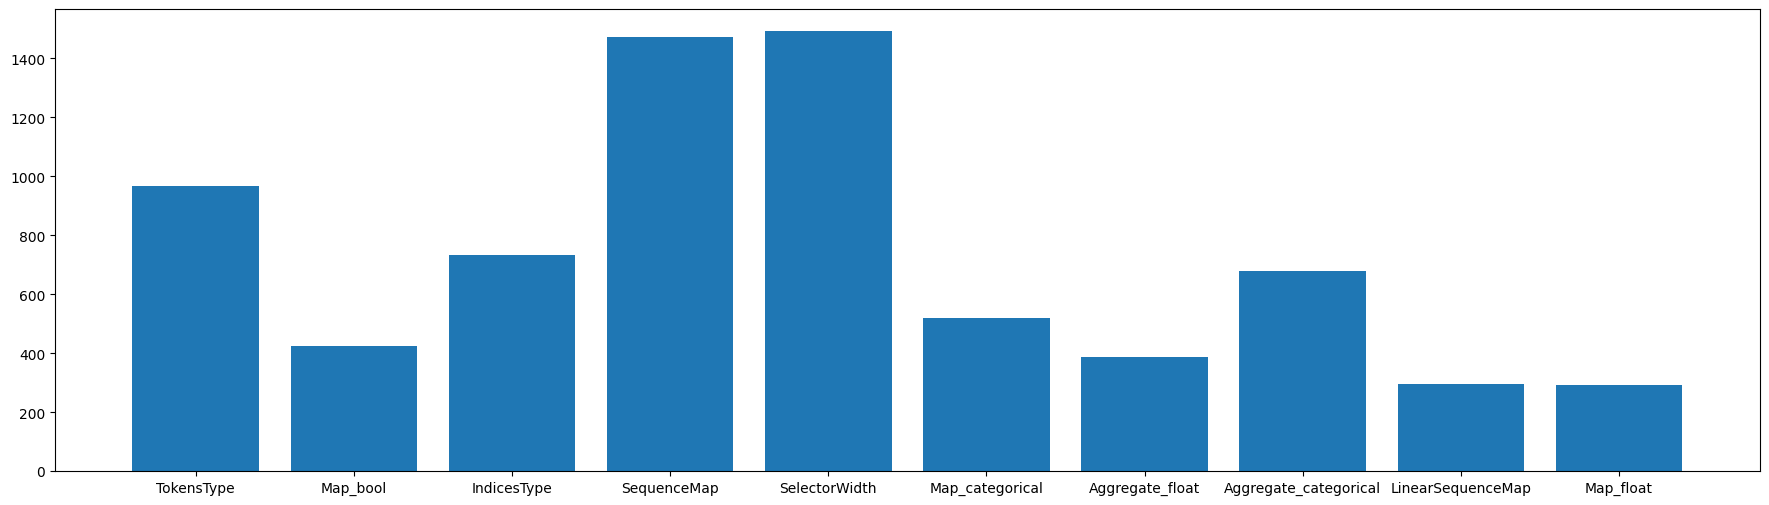

In [ ]:
plt.figure(figsize=(22,6))
plt.bar(total_stats.keys(), total_stats.values())

In [ ]:
plt.hist(lengths, bins=20)
plt.xlabel("Program length")